# Text Classification of Recipes using DistilBERT 

## 0. Introduction

In this notebook, we fine-tune and evaluate the pretrained [DistilBert](https://arxiv.org/abs/1910.01108) model on the recipe.xlsx dataset 

We implement Simple Transformer's [binary classifier](https://github.com/ThilinaRajapakse/simpletransformers) that uses [Hugging Face's PyTorch implementation](https://github.com/huggingface/transformers/tree/master/src/transformers/models/distilbert) based Google's [BERT](https://github.com/google-research/bert).

The goals of this notebook are:
1. Analyze the dataset and discuss any ethical concerns therein
2. Perform transfer learning using the dataset to finetune larger pretrained language models
3. Discuss results and further opportunities for research

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from pathlib import Path
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from tqdm import notebook
import matplotlib.pyplot as plt
import seaborn as sns
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import logging
from sklearn.model_selection import StratifiedKFold
import ast
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
import re
import torch

In [2]:
# !nvidia-smi

## 1 Importing the data
Our first steps will be importing the data and doing initial preprocessing
We are looking for how the columns are laid out, if there are any missing values and how
the data is distributed

In [3]:
data_dir = './'
path = Path(data_dir)

In [4]:
recipe_file = Path(data_dir, 'recipes.xlsx')

In [5]:
df = pd.read_excel(recipe_file, engine='openpyxl') 
print("Shape of data=>",df.shape)
#preliminary data loading and analysis

Shape of data=> (1000, 4)


In [6]:
df.dtypes, [type(cell) for cell in df.iloc[0]]

(id                 int64
 cooking_steps     object
 ingredients       object
 is_good_recipe      bool
 dtype: object,
 [numpy.int64, str, str, numpy.bool_])

looks like ingredients and cookings_steps are coded as string and we want lists

In [7]:
# literal_eval takes the string column values and runs them as though they are python code
df['ingredients'] = df['ingredients'].apply(ast.literal_eval)
df['cooking_steps'] = df['cooking_steps'].apply(ast.literal_eval)

In [8]:
df=df[['cooking_steps','ingredients','is_good_recipe']]
# I get rid of unwanted columns in particular, id
df['cooking_steps_str'] = df['cooking_steps'].apply(lambda x: '. '.join(x))
df['ingredients_str'] = df['ingredients'].apply(lambda x: ', '.join(x))
# rearranging columns
df[['is_good_recipe']+[col for col in df.columns if col!='is_good_recipe']]

,is_good_recipe,cooking_steps,ingredients,cooking_steps_str,ingredients_str
0,True,"[make a choice and proceed with recipe, depend...","[winter squash, mexican seasoning, mixed spice...",make a choice and proceed with recipe. dependi...,"winter squash, mexican seasoning, mixed spice,..."
1,True,"[preheat oven to 425 degrees f, press dough in...","[prepared pizza crust, sausage patty, eggs, mi...",preheat oven to 425 degrees f. press dough int...,"prepared pizza crust, sausage patty, eggs, mil..."
2,True,"[brown ground beef in large pot, add chopped o...","[ground beef, yellow onions, diced tomatoes, t...",brown ground beef in large pot. add chopped on...,"ground beef, yellow onions, diced tomatoes, to..."
3,True,[place potatoes in a large pot of lightly salt...,"[spreadable cheese with garlic and herbs, new ...",place potatoes in a large pot of lightly salte...,"spreadable cheese with garlic and herbs, new p..."
4,True,"[mix all ingredients& boil for 2 1 / 2 hours ,...","[tomato juice, apple cider vinegar, sugar, sal...","mix all ingredients& boil for 2 1 / 2 hours , ...","tomato juice, apple cider vinegar, sugar, salt..."
...,...,...,...,...,...
995,False,[mix lightly and enjoy],[],mix lightly and enjoy,
996,False,"[for the salad:, arrange 3 slices of apple on ...","[apple cider, shallots, fresh thyme, red wine ...",for the salad:. arrange 3 slices of apple on t...,"apple cider, shallots, fresh thyme, red wine v..."
997,False,"[add the oil and 2 tablespoons water, stir in ...","[light brown sugar, eggs, vegetable oil, pumpk...",add the oil and 2 tablespoons water. stir in t...,"light brown sugar, eggs, vegetable oil, pumpki..."
998,False,"[sift dry ingredients together, bake 25-30 min...","[sugar, butter, egg, flour, salt, cocoa, cinna...",sift dry ingredients together. bake 25-30 minu...,"sugar, butter, egg, flour, salt, cocoa, cinnam..."


### 1.1 Preparing the Data for Plotting and Baseline Models
Our next couple steps involve creating new dataframe columns 
removing stopwords and punctuation and plotting the most frequent 
and least frequent words to see if they give us any intuitions about the 
data. 

In [9]:
stop = list(stopwords.words('english'))

In [10]:
df['cooking_steps_str_test'] = df['cooking_steps_str'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['ingredients_str_test'] = df['ingredients_str'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [11]:
df['cooking_steps_str_test'] = df['cooking_steps_str_test'].str.replace(r'[^a-zA-Z\s]+', '').replace(r'\s+', ' ')

<ipython-input-11-1a5738926b9c>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['cooking_steps_str_test'] = df['cooking_steps_str_test'].str.replace(r'[^a-zA-Z\s]+', '').replace(r'\s+', ' ')


In [12]:
df['cooking_steps_str_test'].head()

0    make choice proceed recipe depending size squa...
1    preheat oven  degrees f press dough bottom sid...
2    brown ground beef large pot add chopped onions...
3    place potatoes large pot lightly salted water ...
4    mix ingredients boil     hours  thick pour jar...
Name: cooking_steps_str_test, dtype: object

In [13]:
df['ingredients_str_test'] = df['ingredients_str_test'].str.replace(r'[^a-zA-Z\s]+', '').replace(r'\s+', ' ') # removing punctuation and standardizing whitespace

<ipython-input-13-81150905339e>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['ingredients_str_test'] = df['ingredients_str_test'].str.replace(r'[^a-zA-Z\s]+', '').replace(r'\s+', ' ') # removing punctuation and standardizing whitespace


### 1.2 Plotting our initial observations
Below we can see culinary words that we expect to see as more frequent in both cooking steps and ingredients columns
Our least frequent words on the other hand are more niche cooking techniques or rare ingredients

Text(0, 0.5, 'Word')

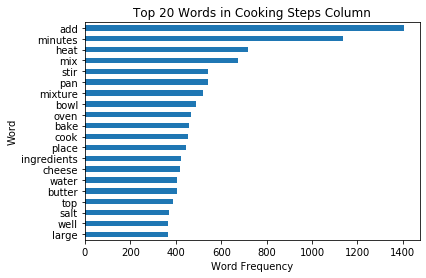

In [14]:
wf_big = pd.Series(' '.join(df['cooking_steps_str_test']).lower().split()).value_counts()[:20].sort_values().plot(kind = 'barh',title='Top 20 Words in Cooking Steps Column')
wf_big.set_xlabel("Word Frequency")
wf_big.set_ylabel("Word")

Text(0, 0.5, 'Word')

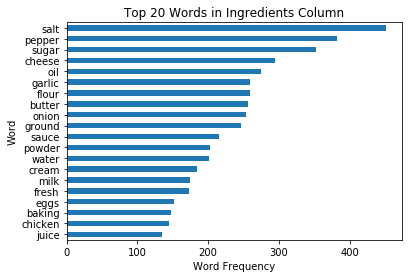

In [15]:
wf_big2 = pd.Series(' '.join(df['ingredients_str_test']).lower().split()).value_counts()[:20].sort_values().plot(kind = 'barh',title='Top 20 Words in Ingredients Column')
wf_big2.set_xlabel("Word Frequency")
wf_big2.set_ylabel("Word")

Text(0, 0.5, 'Word')

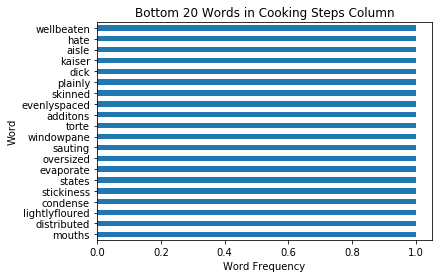

In [16]:
wf_big3 = pd.Series(' '.join(df['cooking_steps_str_test']).lower().split()).value_counts()[-20:].sort_values().plot(kind = 'barh',title='Bottom 20 Words in Cooking Steps Column')
wf_big3.set_xlabel("Word Frequency")
wf_big3.set_ylabel("Word")

Text(0, 0.5, 'Word')

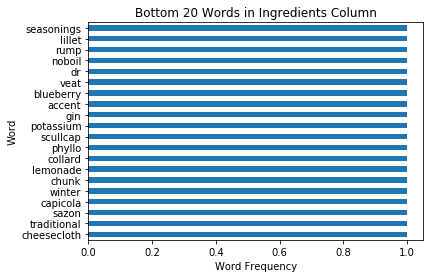

In [17]:
wf_big4 = pd.Series(' '.join(df['ingredients_str_test']).lower().split()).value_counts()[-20:].sort_values().plot(kind = 'barh',title='Bottom 20 Words in Ingredients Column')
wf_big4.set_xlabel("Word Frequency")
wf_big4.set_ylabel("Word")

The step below combines the cooking steps column and ingredients column for my binary classifers below A similar method was used in RecipeNLG...(Bien et al 2020) however we chose to forgo using tokens to mark the beginning and ends of the columns

In [18]:
def concat_method(row):
    total_str = f"ingredients: {row['ingredients_str']}. method: {row['cooking_steps_str']}."
    return total_str

concatenated_method_and_ingredients = df.apply(concat_method, axis=1)
df['steps_and_ingredients'] = concatenated_method_and_ingredients

In [19]:
df['steps_and_ingredients'].iloc[10]

'ingredients: whole berry cranberry sauce, sour cream, prepared horseradish. method: in medium size bowl , coarsely mash cranberry sauce. stir in sour cream and horseradish until well blended.'

In [20]:
steps_ingrd = df[['steps_and_ingredients', 'is_good_recipe']]

In [21]:
steps_ingrd.iloc[50]

steps_and_ingredients    ingredients: flour, water, dry yeast, milk, su...
is_good_recipe                                                        True
Name: 50, dtype: object

In [23]:
steps_ingrd.shape,steps_ingrd.drop_duplicates(subset='steps_and_ingredients').shape

((1000, 2), (1000, 2))

In [24]:
steps_ingrd.head()

,steps_and_ingredients,is_good_recipe
0,"ingredients: winter squash, mexican seasoning,...",True
1,"ingredients: prepared pizza crust, sausage pat...",True
2,"ingredients: ground beef, yellow onions, diced...",True
3,ingredients: spreadable cheese with garlic and...,True
4,"ingredients: tomato juice, apple cider vinegar...",True


In [25]:
recipe_cleaned_csv = 'concatenated_recipe_df.csv'
train_path = Path(data_dir, recipe_cleaned_csv)

In [26]:
steps_ingrd.to_csv(train_path, index=False)

Below I'm checking for the distribution of sequence length by a count of words split on whitespace
Many transformer models have a fixed sequence that's required, such as BERT which is 512 
And since we will be finetuning a transformer model below, this is a necessary step
I check to see how many of the concatenated method/ingredients rows are over 500
And since there aren't many I drop those for the sake of being able to use a variety of models

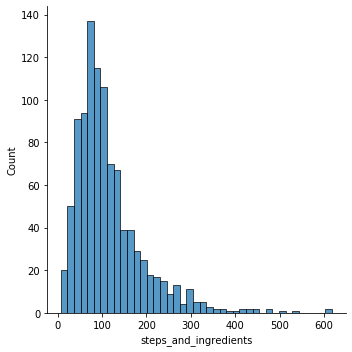

In [27]:
sns.displot(steps_ingrd['steps_and_ingredients'].apply(lambda x: len(x.split(' '))), height=5)

In [28]:
steps_ingrd[steps_ingrd['steps_and_ingredients'].apply(lambda x: len(x.split(' '))) > 512] #here are examples of sequences which are greater than 512

,steps_and_ingredients,is_good_recipe
207,"ingredients: unsweetened cocoa, espresso, butt...",True
316,"ingredients: white flour, milk, fat, egg, suga...",True
688,"ingredients: all-purpose white flour, salt, un...",False
887,"ingredients: fast rising yeast, warm water, wh...",False


In [29]:
steps_ingrd['is_good_recipe'] = steps_ingrd['is_good_recipe'].astype(int) #here I'm turning the true and false values into 0 and 1's since BERT and similar models require labels in this format

<ipython-input-29-286f2dda8359>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steps_ingrd['is_good_recipe'] = steps_ingrd['is_good_recipe'].astype(int) #here I'm turning the true and false values into 0 and 1's since BERT and similar models require labels in this format


In [30]:
steps_ingrd.is_good_recipe.value_counts()

0    500
1    500
Name: is_good_recipe, dtype: int64

## 2. Train and Evaluate Baseline Models
Below we will be using various Naive Bayes models as a baseline for classification, one of the benefits of which is fast training time
We will use TF-IDF to turn our concatenated steps and ingredients column into a vectored representation
TF-IDF shows the rarity of a word in our dataset. If a word is rare then in theory this word is particularly helpful in determining if a recipe is good or not.
We will be using K-fold Cross Validation which I will explain in further detail below


In [31]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_val_predict
def make_pipe_from_classifier(classifier_name, classifier):
    ''' assuming every classifier of interest will take tf-idf as input'''
    return Pipeline([('tf-idf', TfidfVectorizer()), (classifier_name, classifier())])

#First baseline model we will explore is Naive Bayes, will be using Bernoulli since it works best for binary classification
bernoulli_pipe = make_pipe_from_classifier('BNB', BernoulliNB)

#The next baseline model we will be looking at is Logistic regression
log_regression_pipe = make_pipe_from_classifier('L_R', LogisticRegression)

svm_pipe = make_pipe_from_classifier('SVM', svm.SVC)


pipe_cvpreds_dict = dict()
for ppipe in [bernoulli_pipe, log_regression_pipe, svm_pipe]:
    pipe_cvpreds_dict[ppipe.steps[1][0]]  = cross_val_predict(ppipe, X=steps_ingrd['steps_and_ingredients'], y=steps_ingrd['is_good_recipe'], cv=skf.split(X=steps_ingrd['steps_and_ingredients'], y=steps_ingrd['is_good_recipe']))


In [32]:
for classifier, preds in pipe_cvpreds_dict.items():
    print(f'_____________{classifier} 5-fold predictions_________')
    print(classification_report(steps_ingrd['is_good_recipe'], preds, digits=3))

_____________BNB 5-fold predictions_________
              precision    recall  f1-score   support

           0      0.576     0.656     0.614       500
           1      0.601     0.518     0.556       500

    accuracy                          0.587      1000
   macro avg      0.589     0.587     0.585      1000
weighted avg      0.589     0.587     0.585      1000

_____________L_R 5-fold predictions_________
              precision    recall  f1-score   support

           0      0.620     0.580     0.599       500
           1      0.605     0.644     0.624       500

    accuracy                          0.612      1000
   macro avg      0.612     0.612     0.612      1000
weighted avg      0.612     0.612     0.612      1000

_____________SVM 5-fold predictions_________
              precision    recall  f1-score   support

           0      0.621     0.564     0.591       500
           1      0.601     0.656     0.627       500

    accuracy                          0.610    

 As you can see none of these simple models perform very well despite the speed of execution
 We will be moving to our main approach which is using transformers and transfer learning to finetune a large language model
 The language model we will be working on will be DistilBERT

 For our train/validation split we will be doing K-fold cross validation and a small grid search to find the optimal time for training epochs

In [33]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

step one take 10% of data don't look until the end. This is the test set. and is only used to give a generalision error estimate of your best final chosen model.


In [34]:
df_train_t,  df_test_t = train_test_split(steps_ingrd,test_size=0.10, random_state=42) #splitting the data set into train/test and  holding back 10% of the data for validation

##  Why Kfold?  The dataset is small so it's  more affordable.
When the dataset is small taking a random 20% for testing is a gamble that that 20% is representative of the data.
In this case we think it is better to use all of data as test and aggregate results.

## 3.  Finetune our main model
Below we will use transfer learning to finetune our large pre-trained language models DistilBert

In [35]:
cuda_available = torch.cuda.is_available()
skf = StratifiedKFold(n_splits=5,random_state=42, shuffle=True)

epoch2mcc = dict()
for i in [1,2,3,4,5,6,7,8,9,10]:
    results = []
    # Create a TransformerModel
    model_args = ClassificationArgs()
    model_args.num_train_epochs = i
    model_args.overwrite_output_dir = True
    model_args.evaluate_during_training=True
    model_args.max_seq_length=512
    model_args.use_cuda=cuda_available
    model_args.do_lower_case=True
    model_args.use_cached_eval_features=True
    model_args.verbose=False
    for train_inds, test_inds in notebook.tqdm(skf.split(df_train_t['steps_and_ingredients'], df_train_t['is_good_recipe'])):
        train_df = steps_ingrd.iloc[train_inds]
        test_df = steps_ingrd.iloc[test_inds]
#         print(train_df.head())
        # Train the model
        model = ClassificationModel('distilbert', 'distilbert-base-uncased', args=model_args)
        model.train_model(train_df, eval_df=test_df, output_dir=f'./outputs/train_epochs_{i}')
        # Evaluate the model
        result, model_outputs, wrong_predictions = model.eval_model(test_df)
        results.append(result['mcc'])
    epoch2mcc[i] = np.array(results)

0it [00:00, ?it/s]

INFO:filelock:Lock 1685038402144 acquired on C:\Users\Rory/.cache\huggingface\transformers\23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.d423bdf2f58dc8b77d5f5d18028d7ae4a72dcfd8f468e81fe979ada957a8c361.lock


Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

INFO:filelock:Lock 1685038402144 released on C:\Users\Rory/.cache\huggingface\transformers\23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.d423bdf2f58dc8b77d5f5d18028d7ae4a72dcfd8f468e81fe979ada957a8c361.lock
INFO:filelock:Lock 1685129139872 acquired on C:\Users\Rory/.cache\huggingface\transformers\9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a.lock


Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

INFO:filelock:Lock 1685129139872 released on C:\Users\Rory/.cache\huggingface\transformers\9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a.lock
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassi

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

INFO:filelock:Lock 1685130726800 released on C:\Users\Rory/.cache\huggingface\transformers\45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:445: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_1.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_disti

Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.15705435116106561, 'tp': 71, 'tn': 36, 'fp': 36, 'fn': 37, 'auroc': 0.6471836419753086, 'auprc': 0.7310643309260052, 'eval_loss': 0.665627165980961}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificatio

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_1.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.31426968052735443, 'tp': 93, 'tn': 30, 'fp': 42, 'fn': 15, 'auroc': 0.7267232510288065, 'auprc': 0.8005970015783956, 'eval_loss': 0.6154186090697413}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificati

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_1.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.25704521992169155, 'tp': 104, 'tn': 14, 'fp': 58, 'fn': 4, 'auroc': 0.729295267489712, 'auprc': 0.7786249689374962, 'eval_loss': 0.6424272189969602}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificatio

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_1.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.25409285965892153, 'tp': 106, 'tn': 11, 'fp': 61, 'fn': 2, 'auroc': 0.7277520576131689, 'auprc': 0.7930066151870762, 'eval_loss': 0.6217512566110363}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificati

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_1.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.296683051981965, 'tp': 73, 'tn': 45, 'fp': 27, 'fn': 35, 'auroc': 0.75, 'auprc': 0.8313909699971169, 'eval_loss': 0.6407095789909363}


0it [00:00, ?it/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 2:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_2.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.30011117287763484, 'tp': 96, 'tn': 26, 'fp': 46, 'fn': 12, 'auroc': 0.7960390946502057, 'auprc': 0.8416424358067564, 'eval_loss': 0.5777644683485446}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificati

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 2:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_2.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.565858873431096, 'tp': 94, 'tn': 49, 'fp': 23, 'fn': 14, 'auroc': 0.8795010288065844, 'auprc': 0.915745178590328, 'eval_loss': 0.4480546894280807}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification 

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 2:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_2.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.6005258346707544, 'tp': 88, 'tn': 57, 'fp': 15, 'fn': 20, 'auroc': 0.8710133744855967, 'auprc': 0.9131559555810633, 'eval_loss': 0.45495631448600604}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificati

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 2:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_2.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.592436845747129, 'tp': 92, 'tn': 53, 'fp': 19, 'fn': 16, 'auroc': 0.8679269547325102, 'auprc': 0.9109190057964472, 'eval_loss': 0.4601792511732682}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 2:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_2.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5677185985747704, 'tp': 92, 'tn': 51, 'fp': 21, 'fn': 16, 'auroc': 0.8734567901234568, 'auprc': 0.908863821260134, 'eval_loss': 0.46490144211313}


0it [00:00, ?it/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 3:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 3:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_3.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.45646427904835885, 'tp': 97, 'tn': 37, 'fp': 35, 'fn': 11, 'auroc': 0.8283179012345679, 'auprc': 0.8750586086455269, 'eval_loss': 0.5528835680173791}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificati

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 3:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 3:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_3.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.7671628886679961, 'tp': 101, 'tn': 59, 'fp': 13, 'fn': 7, 'auroc': 0.9362139917695474, 'auprc': 0.9503121474649885, 'eval_loss': 0.3177679113071898}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificatio

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 3:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 3:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_3.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.8492450833098989, 'tp': 102, 'tn': 65, 'fp': 7, 'fn': 6, 'auroc': 0.9692644032921811, 'auprc': 0.9787382306020445, 'eval_loss': 0.22243050615424695}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificatio

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 3:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 3:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_3.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.8142280965617381, 'tp': 103, 'tn': 61, 'fp': 11, 'fn': 5, 'auroc': 0.9586548353909464, 'auprc': 0.9710342423834067, 'eval_loss': 0.2643003615996112}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificatio

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 3:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 3:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_3.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.3834753875658667, 'tp': 99, 'tn': 29, 'fp': 43, 'fn': 9, 'auroc': 0.7916666666666667, 'auprc': 0.8536608938298518, 'eval_loss': 0.5654244047144185}


0it [00:00, ?it/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 4:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 4:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 4:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_4.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5099028097099878, 'tp': 89, 'tn': 49, 'fp': 23, 'fn': 19, 'auroc': 0.8510802469135803, 'auprc': 0.8494711903427347, 'eval_loss': 0.6384748761420664}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificatio

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 4:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 4:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 4:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_4.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.849941194518708, 'tp': 101, 'tn': 66, 'fp': 6, 'fn': 7, 'auroc': 0.967013888888889, 'auprc': 0.9603232372058667, 'eval_loss': 0.201084995723289}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mo

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 4:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 4:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 4:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_4.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.8841434039925478, 'tp': 105, 'tn': 65, 'fp': 7, 'fn': 3, 'auroc': 0.9837962962962963, 'auprc': 0.9829859872615413, 'eval_loss': 0.16733134367867655}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificatio

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 4:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 4:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 4:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_4.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.988465588770538, 'tp': 108, 'tn': 71, 'fp': 1, 'fn': 0, 'auroc': 0.999485596707819, 'auprc': 0.9996554321496063, 'eval_loss': 0.0362081626308677}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification m

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 4:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 4:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 4:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_4.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.9770084209183945, 'tp': 108, 'tn': 70, 'fp': 2, 'fn': 0, 'auroc': 1.0, 'auprc': 1.0000000000000002, 'eval_loss': 0.03125175837751316}


0it [00:00, ?it/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_5.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.517499258790655, 'tp': 93, 'tn': 46, 'fp': 26, 'fn': 15, 'auroc': 0.8361625514403292, 'auprc': 0.8760821043172288, 'eval_loss': 0.8108811795144625}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_5.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.872448500886672, 'tp': 103, 'tn': 66, 'fp': 6, 'fn': 5, 'auroc': 0.9768518518518519, 'auprc': 0.9821601717288166, 'eval_loss': 0.20758451561888921}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_5.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.8749414513556443, 'tp': 107, 'tn': 62, 'fp': 10, 'fn': 1, 'auroc': 0.9777520576131687, 'auprc': 0.98410549591607, 'eval_loss': 0.204827804847256}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification m

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_5.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.9768518518518519, 'tp': 107, 'tn': 71, 'fp': 1, 'fn': 1, 'auroc': 0.9891975308641976, 'auprc': 0.9880571444982905, 'eval_loss': 0.06070822523906827}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificatio

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 5:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_5.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.8860270884328433, 'tp': 107, 'tn': 63, 'fp': 9, 'fn': 1, 'auroc': 0.9748585390946501, 'auprc': 0.9701331577471191, 'eval_loss': 0.1520121129958526}


0it [00:00, ?it/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 5 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_6.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.7319347221294561, 'tp': 99, 'tn': 58, 'fp': 14, 'fn': 9, 'auroc': 0.9133230452674898, 'auprc': 0.9254665868036841, 'eval_loss': 0.6485918430085091}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 5 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_6.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.9770084209183945, 'tp': 108, 'tn': 70, 'fp': 2, 'fn': 0, 'auroc': 0.9996141975308641, 'auprc': 0.9997459159496199, 'eval_loss': 0.06750410983500921}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificatio

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 5 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_6.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.8839599998785473, 'tp': 104, 'tn': 66, 'fp': 6, 'fn': 4, 'auroc': 0.9920267489711934, 'auprc': 0.9948913571075086, 'eval_loss': 0.14226706775472217}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificatio

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 5 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_6.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 1.0, 'tp': 108, 'tn': 72, 'fp': 0, 'fn': 0, 'auroc': 1.0, 'auprc': 1.0000000000000002, 'eval_loss': 0.0025622383134601555}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Di

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 5 of 6:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_6.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.9192298788544723, 'tp': 104, 'tn': 69, 'fp': 3, 'fn': 4, 'auroc': 0.9893904320987654, 'auprc': 0.9926739122175452, 'eval_loss': 0.1395108170159485}


0it [00:00, ?it/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 0 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 5 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 6 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_7.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.4973402599084766, 'tp': 89, 'tn': 48, 'fp': 24, 'fn': 19, 'auroc': 0.8439429012345679, 'auprc': 0.8719131381815962, 'eval_loss': 1.2955068335868418}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificatio

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 0 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
C:\Users\Rory\.conda\envs\dl\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running Epoch 1 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 5 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 6 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_7.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.9188553360402184, 'tp': 105, 'tn': 68, 'fp': 4, 'fn': 3, 'auroc': 0.987011316872428, 'auprc': 0.9895056513138403, 'eval_loss': 0.1267377369146308}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification 

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 0 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
C:\Users\Rory\.conda\envs\dl\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running Epoch 1 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 5 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 6 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_7.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.988465588770538, 'tp': 108, 'tn': 71, 'fp': 1, 'fn': 0, 'auroc': 0.9999999999999999, 'auprc': 1.0000000000000002, 'eval_loss': 0.027357897174585123}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificatio

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 0 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 5 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 6 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_7.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.9768518518518519, 'tp': 107, 'tn': 71, 'fp': 1, 'fn': 1, 'auroc': 0.9997427983539094, 'auprc': 0.9998293187853161, 'eval_loss': 0.03411626888682013}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificatio

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 0 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 5 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 6 of 7:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_7.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.988465588770538, 'tp': 108, 'tn': 71, 'fp': 1, 'fn': 0, 'auroc': 0.9998713991769548, 'auprc': 0.9999150526673464, 'eval_loss': 0.03631005887164856}


0it [00:00, ?it/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 5 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 6 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 7 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_8.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.5318368491992856, 'tp': 91, 'tn': 49, 'fp': 23, 'fn': 17, 'auroc': 0.8497942386831276, 'auprc': 0.8852110800234232, 'eval_loss': 1.1030695758274067}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificatio

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 5 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 6 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 7 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_8.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 1.0, 'tp': 108, 'tn': 72, 'fp': 0, 'fn': 0, 'auroc': 1.0, 'auprc': 1.0, 'eval_loss': 0.0005695032052007382}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequ

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
C:\Users\Rory\.conda\envs\dl\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running Epoch 1 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 5 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 6 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 7 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_8.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 1.0, 'tp': 108, 'tn': 72, 'fp': 0, 'fn': 0, 'auroc': 1.0, 'auprc': 1.0, 'eval_loss': 0.0005146170619611993}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequ

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 5 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 6 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 7 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_8.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 1.0, 'tp': 108, 'tn': 72, 'fp': 0, 'fn': 0, 'auroc': 1.0, 'auprc': 1.0, 'eval_loss': 0.0004707250754227457}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequ

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 5 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 6 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 7 of 8:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_8.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.988465588770538, 'tp': 108, 'tn': 71, 'fp': 1, 'fn': 0, 'auroc': 0.9998713991769547, 'auprc': 0.9999150526673464, 'eval_loss': 0.03311937529107799}


0it [00:00, ?it/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 0 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 5 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 6 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 7 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 8 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_9.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.6133324548629985, 'tp': 97, 'tn': 50, 'fp': 22, 'fn': 11, 'auroc': 0.8951260288065843, 'auprc': 0.9140862912565423, 'eval_loss': 1.0524841906748328}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificatio

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 0 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 5 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 6 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 7 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 8 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_9.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.988465588770538, 'tp': 108, 'tn': 71, 'fp': 1, 'fn': 0, 'auroc': 0.9990997942386832, 'auprc': 0.9993883216680943, 'eval_loss': 0.03622222664948229}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 0 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 5 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 6 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 7 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 8 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_9.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 1.0, 'tp': 108, 'tn': 72, 'fp': 0, 'fn': 0, 'auroc': 1.0, 'auprc': 1.0, 'eval_loss': 0.0028486500048766966}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequ

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 0 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 5 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 6 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 7 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 8 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_9.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 1.0, 'tp': 108, 'tn': 72, 'fp': 0, 'fn': 0, 'auroc': 1.0, 'auprc': 1.0, 'eval_loss': 0.0008216282712174175}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequ

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 0 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 5 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 6 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 7 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 8 of 9:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_9.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 1.0, 'tp': 108, 'tn': 72, 'fp': 0, 'fn': 0, 'auroc': 1.0, 'auprc': 1.0, 'eval_loss': 0.003790240593092597}


0it [00:00, ?it/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 5 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 6 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 7 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 8 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 9 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_10.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.6270894413356963, 'tp': 100, 'tn': 48, 'fp': 24, 'fn': 8, 'auroc': 0.8661908436213991, 'auprc': 0.8898219306166897, 'eval_loss': 1.2191063315334285}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificatio

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 5 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 6 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 7 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 8 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 9 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_10.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 1.0, 'tp': 108, 'tn': 72, 'fp': 0, 'fn': 0, 'auroc': 1.0, 'auprc': 1.0, 'eval_loss': 0.0003007943925457885}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequ

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 5 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 6 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 7 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 8 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 9 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_10.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 1.0, 'tp': 108, 'tn': 72, 'fp': 0, 'fn': 0, 'auroc': 1.0, 'auprc': 1.0, 'eval_loss': 0.00017637311184839547}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSeq

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 5 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 6 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 7 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 8 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 9 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_10.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.988465588770538, 'tp': 108, 'tn': 71, 'fp': 1, 'fn': 0, 'auroc': 1.0, 'auprc': 1.0, 'eval_loss': 0.01202546449823548}
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Disti

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_512_2_720


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 1 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 2 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 3 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 4 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 5 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 6 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 7 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 8 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Epoch 9 of 10:   0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180
INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to ./outputs/train_epochs_10.
C:\Users\Rory\AppData\Roaming\Python\Python38\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_512_2_180


Running Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 1.0, 'tp': 108, 'tn': 72, 'fp': 0, 'fn': 0, 'auroc': 1.0, 'auprc': 1.0000000000000002, 'eval_loss': 0.0005518814989203668}


# 4. Results from our main model and conclusive thoughts
As we can observe due to our grid search, the optimal training time seems to be around 9 epochs
furthermore there are great improvements to precision, recall, and accuracy.
For further improvements we would explore other large pre-trained models such as XLnet, and Electra
Furthermore we would extend our classifer to be able multiclass using new unseen data scraped from various recipe sites and user
site reviews to create labels. 

train for 1 epochs: avg mcc:0.25582903265019963
train for 2 epochs: avg mcc:0.5253302650602769
train for 3 epochs: avg mcc:0.6541151470307718
train for 4 epochs: avg mcc:0.8418922835820354
train for 5 epochs: avg mcc:0.8255536302635333
train for 6 epochs: avg mcc:0.902426604356174
train for 7 epochs: avg mcc:0.8739957250683246
train for 8 epochs: avg mcc:0.9040604875939648
train for 9 epochs: avg mcc:0.9203596087267073
train for 10 epochs: avg mcc:0.9231110060212468


C:\Users\Rory\.conda\envs\dl\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Rory\.conda\envs\dl\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Rory\.conda\envs\dl\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` 

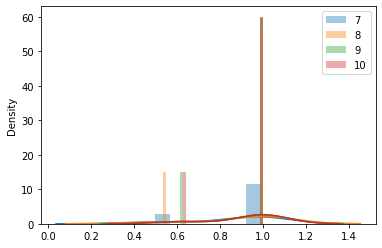

In [36]:
for k,v in epoch2mcc.items():
    if k > 6:
        sns.distplot(v, label=str(k))
    print(f'train for {k} epochs: avg mcc:{np.mean(v)}')
plt.legend()

In [37]:
epoch2mcc

{1: array([0.15705435, 0.31426968, 0.25704522, 0.25409286, 0.29668305]),
 2: array([0.30011117, 0.56585887, 0.60052583, 0.59243685, 0.5677186 ]),
 3: array([0.45646428, 0.76716289, 0.84924508, 0.8142281 , 0.38347539]),
 4: array([0.50990281, 0.84994119, 0.8841434 , 0.98846559, 0.97700842]),
 5: array([0.51749926, 0.8724485 , 0.87494145, 0.97685185, 0.88602709]),
 6: array([0.73193472, 0.97700842, 0.88396   , 1.        , 0.91922988]),
 7: array([0.49734026, 0.91885534, 0.98846559, 0.97685185, 0.98846559]),
 8: array([0.53183685, 1.        , 1.        , 1.        , 0.98846559]),
 9: array([0.61333245, 0.98846559, 1.        , 1.        , 1.        ]),
 10: array([0.62708944, 1.        , 1.        , 0.98846559, 1.        ])}

In [38]:
result

{'mcc': 1.0,
 'tp': 108,
 'tn': 72,
 'fp': 0,
 'fn': 0,
 'auroc': 1.0,
 'auprc': 1.0000000000000002,
 'eval_loss': 0.0005518814989203668}

In [39]:
preds = model.predict(df_test_t['steps_and_ingredients'].tolist())[0]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_512_2_100


  0%|          | 0/13 [00:00<?, ?it/s]

In [40]:
print(classification_report(df_test_t['is_good_recipe'], preds))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        52
           1       0.98      0.98      0.98        48

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100

